### Aim of this notebook is to predict the forward return of stocks in the S&P 500 Index. To start with, we will simply predict the sign of the return (Positive, Negative, Zero) but can later move on to regression.

# Imports

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Get data

In [2]:
# Get raw data
companies = pd.read_csv("/kaggle/input/sp-500-stocks/sp500_companies.csv")
index = pd.read_csv("/kaggle/input/sp-500-stocks/sp500_index.csv", parse_dates=['Date'])
stocks = pd.read_csv("/kaggle/input/sp-500-stocks/sp500_stocks.csv", parse_dates=['Date'])

In [3]:
companies.head(10)

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,416.420,3094183936000,1.184270e+11,0.176,Redmond,WA,United States,221000.0,Microsoft Corporation develops and supports so...,0.065276
1,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,172.620,2665580593152,1.301090e+11,0.021,Cupertino,CA,United States,161000.0,"Apple Inc. designs, manufactures, and markets ...",0.056234
2,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,878.365,2195912523776,3.448000e+10,2.653,Santa Clara,CA,United States,29600.0,"NVIDIA Corporation provides graphics, and comp...",0.046326
3,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,174.420,1811770245120,8.551500e+10,0.139,Seattle,WA,United States,1525000.0,"Amazon.com, Inc. engages in the retail sale of...",0.038222
4,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,142.170,1761315782656,1.001720e+11,0.135,Mountain View,CA,United States,182502.0,Alphabet Inc. offers various products and plat...,0.037157
5,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,141.180,1760556875776,1.001720e+11,0.135,Mountain View,CA,United States,182502.0,Alphabet Inc. offers various products and plat...,0.037141
6,NMS,META,"Meta Platforms, Inc.","Meta Platforms, Inc.",Communication Services,Internet Content & Information,484.100,1234169364480,6.138100e+10,0.247,Menlo Park,CA,United States,67317.0,"Meta Platforms, Inc. engages in the developmen...",0.026036
7,NYQ,BRK-B,Berkshire Hathaway Inc. New,Berkshire Hathaway Inc.,Financial Services,Insurance - Diversified,408.130,885225816064,1.356820e+11,0.196,Omaha,NE,United States,396500.0,"Berkshire Hathaway Inc., through its subsidiar...",0.018675
8,NYQ,LLY,Eli Lilly and Company,Eli Lilly and Company,Healthcare,Drug Manufacturers - General,754.170,716585172992,1.231460e+10,0.281,Indianapolis,IN,United States,43000.0,"Eli Lilly and Company discovers, develops, and...",0.015117
9,NYQ,V,Visa Inc.,Visa Inc.,Financial Services,Credit Services,283.040,581384011776,2.342200e+10,0.088,San Francisco,CA,United States,NaN,Visa Inc. operates as a payment technology com...,0.012265


In [4]:
index.head(10)

,Date,S&P500
0,2014-03-17,1858.83
1,2014-03-18,1872.25
2,2014-03-19,1860.77
3,2014-03-20,1872.01
4,2014-03-21,1866.52
5,2014-03-24,1857.44
6,2014-03-25,1865.62
7,2014-03-26,1852.56
8,2014-03-27,1849.04
9,2014-03-28,1857.62


In [5]:
stocks.head(10)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,59.318886,83.019997,83.449997,82.669998,83.089996,3043700.0
1,2010-01-05,MMM,58.947342,82.500000,83.230003,81.699997,82.800003,2847000.0
2,2010-01-06,MMM,59.783295,83.669998,84.599998,83.510002,83.879997,5268500.0
3,2010-01-07,MMM,59.826176,83.730003,83.760002,82.120003,83.320000,4470100.0
4,2010-01-08,MMM,60.247749,84.320000,84.320000,83.300003,83.690002,3405800.0
5,2010-01-11,MMM,60.004826,83.980003,84.599998,83.410004,84.379997,2927100.0
6,2010-01-12,MMM,60.054844,84.050003,84.180000,83.300003,83.580002,3031800.0
7,2010-01-13,MMM,59.861942,83.779999,84.110001,83.199997,84.110001,3102000.0
8,2010-01-14,MMM,59.661865,83.500000,83.930000,83.419998,83.739998,2634100.0
9,2010-01-15,MMM,59.568989,83.370003,84.089996,82.870003,83.519997,3955000.0


# EDA

Looks like the companies table has some numerical columns but they are only for the latest date so can't be used in our data for ML. We can however use the static columns such as 'Exchange', 'Sector', 'Industry', 'City', 'State', 'Country'.

The index table simply gives the value of the whole index over time but only from 2014 onwards. We may be able to use this as a feature but if the constituents data goes back further, we will be missing that feature in the period before 2014. It's clear to see the index has generally grown but with big drops in 2020 (COVID) and late 2021.

The stocks table contains index constituents from 2010 to 2024. Annoyingly, these constituents are fixed, so they are simply the historical data for today's constituents, rather than including stuff that has fallen out of the index too. This means there is  survivorship bias inherent in the data.

So that we can use the value of the whole index as a feature, we should cut off the stocks table to have the same starting date (2014-02-13). In terms of columns, we can use adjusted close to calculate forward returns.

We should probably only look at a short horizon to calculate forward returns but not too short. This is because looking not far enough ahead will mean noise will have a greater effect. Looking too far ahead will lead to bias in the data since equities tend to go up over time anyway.

Note that adjusted close price is below the other prices mostly as it's been adjusted down to account for the payment of dividends. Furthemore trading volumes are fairly flat but often have large spikes e.g. in 2020 (assume mass selling and then buying after covid.)

In [6]:
# Basic info for companies table.
print(companies.describe())
print("\n")
print(companies.info())

       Currentprice     Marketcap        Ebitda  Revenuegrowth  \
count    503.000000  5.030000e+02  4.740000e+02     502.000000   
mean     211.406014  9.423800e+10  6.518274e+09       0.039020   
std      442.418940  2.636502e+11  1.420751e+10       0.194978   
min        8.540000  4.286295e+09 -3.618000e+09      -0.582000   
25%       62.750000  1.760126e+10  1.477677e+09      -0.043000   
50%      119.900000  3.362782e+10  2.789000e+09       0.036000   
75%      228.375000  7.182374e+10  5.728193e+09       0.107750   
max     7565.870000  3.094184e+12  1.356820e+11       2.653000   

       Fulltimeemployees      Weight  
count       4.920000e+02  503.000000  
mean        5.708132e+04    0.001988  
std         1.388978e+05    0.005562  
min         2.800000e+01    0.000090  
25%         1.023750e+04    0.000371  
50%         2.105000e+04    0.000709  
75%         5.303750e+04    0.001515  
max         2.100000e+06    0.065276  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50

In [7]:
# Basic info for index table
print(index.describe())
print("\n")
print(index.info())

                                Date       S&P500
count                           2518  2518.000000
mean   2019-03-15 00:37:10.341540864  3069.483098
min              2014-03-17 00:00:00  1815.690000
25%              2016-09-13 06:00:00  2163.757500
50%              2019-03-16 12:00:00  2834.405000
75%              2021-09-13 18:00:00  3963.310000
max              2024-03-15 00:00:00  5175.270000
std                              NaN   926.814205


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2518 non-null   datetime64[ns]
 1   S&P500  2518 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.5 KB
None


<Axes: title={'center': 'Value of S&P 500'}, xlabel='Date'>

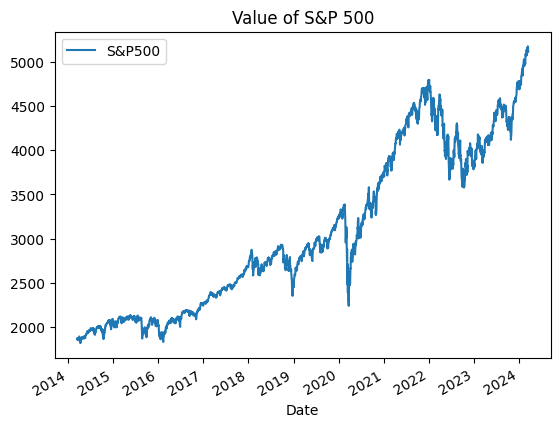

In [8]:
# Plot S&P 500 index value over time
index.plot(x='Date', y='S&P500', title='Value of S&P 500')

In [9]:
# Basic info for stocks table
print(stocks.describe())
print("\n")
print(stocks.info())

                                Date     Adj Close         Close  \
count                        1797722  1.717809e+06  1.717809e+06   
mean   2017-02-06 17:05:48.517067520  9.618129e+01  1.028684e+02   
min              2010-01-04 00:00:00  7.000000e-01  7.000000e-01   
25%              2013-07-23 00:00:00  2.961000e+01  3.523000e+01   
50%              2017-02-07 12:00:00  5.405490e+01  6.197000e+01   
75%              2020-08-26 00:00:00  1.028042e+02  1.115700e+02   
max              2024-03-15 00:00:00  7.746300e+03  7.746300e+03   
std                              NaN  1.964579e+02  1.963057e+02   

               High           Low          Open        Volume  
count  1.717809e+06  1.717809e+06  1.717809e+06  1.717809e+06  
mean   1.039960e+02  1.016803e+02  1.028453e+02  5.892219e+06  
min    7.100000e-01  6.500000e-01  7.000000e-01  0.000000e+00  
25%    3.562000e+01  3.482000e+01  3.522000e+01  9.925000e+05  
50%    6.260000e+01  6.130000e+01  6.196244e+01  2.140300e+06  
75%

In [10]:
# Check if there is any difference in constituents over time
unique_constituents = stocks.groupby('Date')['Symbol'].unique().reset_index()['Symbol']
first_constituents = unique_constituents[0]
difference = False
for u in unique_constituents:
    if len(u) != len(first_constituents):
        print("Length mismatch")
        difference = True
        break
    elif not all(f == x for f, x in zip(first_constituents, u)):
        print("Constituent mismatch")
        difference = True
        break
print(difference)

False


<Axes: xlabel='Date'>

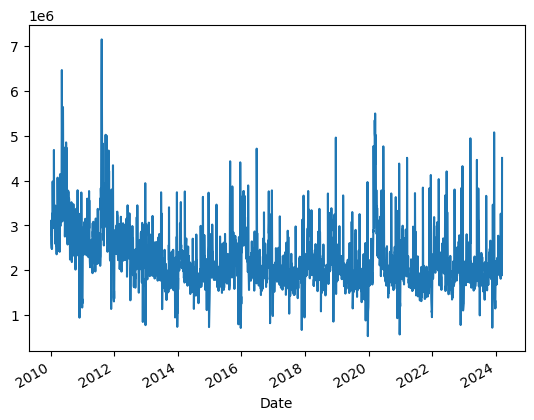

In [11]:
# Plot median trading volume over time
stocks.pivot(index='Date', columns='Symbol', values=['Volume']).median(axis=1).plot()

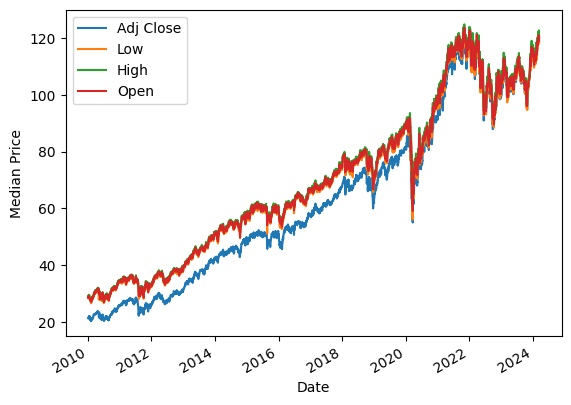

In [12]:
# Plot median prices over time
median_adj_close_prices = stocks.pivot(index='Date', columns='Symbol', values=['Adj Close']).median(axis=1)
median_low_prices = stocks.pivot(index='Date', columns='Symbol', values=['Low']).median(axis=1)
median_high_prices = stocks.pivot(index='Date', columns='Symbol', values=['High']).median(axis=1)
median_open_prices = stocks.pivot(index='Date', columns='Symbol', values=['Open']).median(axis=1)
median_data = pd.DataFrame({
    'Adj Close': median_adj_close_prices,
    'Low': median_low_prices,
    'High': median_high_prices,
    'Open': median_open_prices
})
median_data.plot()
plt.xlabel('Date')
plt.ylabel('Median Price')
plt.legend()
plt.show()


# Data cleaning and feature engineering

First we construct a wider table containing pricing but also the static info for each stock

Next we perform one hot encoding on the categorical features. I have chosen to remove 'Country' because they are mostly US and have removed 'City' since it is highly correlated to 'State'.

Next we generate some SMAs and EMAs as well as Bollinger bands. Note I have plotted them both for AAPL and see how EMA responds more quickly to price changes than SMA. Note also how price somewhat seems to reverse after hitting Bollinger bands, implying that crossover could be used as a signal, so we have added distance to Bollinger Bands as columns.

We then have added MACD. Note when MACD crosses above the signal line, we often get a price increase and when it crosses below the signal line we get a price decrease. However, we do need to be careful of false signals.

Another possible signal could be some sort of short term average minus long term average but normalised for volatility in the averages. For example, we could normalise MACD for volatility as outlined here using the ATR (Average True Range) as a measure of volatility. This indicator is called MACD-V and we plot it in the same way as MACD.

FINALLY, WE DROP UNECESSARY COLUMNS AND THEN WE CAN MOVE ONTO BUILDING THE MODELS.

In [13]:
# Join index table onto stocks table
df = stocks.merge(
    right=index,
    how='left',
    left_on='Date',
    right_on='Date'
)

# Join companies table onto stocks and index table
df = df.merge(
    right=companies[['Symbol', 'Exchange', 'Sector', 'Industry', 'City', 'State', 'Country']],
    how='left',
    left_on='Symbol',
    right_on='Symbol'
)

# Check stocks table and final table have same number of rows to ensure the join is done correctly
print(df.shape)
print(stocks.shape)

(1797722, 15)
(1797722, 8)


In [14]:
df.head(5)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,S&P500,Exchange,Sector,Industry,City,State,Country
0,2010-01-04,MMM,59.318886,83.019997,83.449997,82.669998,83.089996,3043700.0,NaN,NYQ,Industrials,Conglomerates,Saint Paul,MN,United States
1,2010-01-05,MMM,58.947342,82.500000,83.230003,81.699997,82.800003,2847000.0,NaN,NYQ,Industrials,Conglomerates,Saint Paul,MN,United States
2,2010-01-06,MMM,59.783295,83.669998,84.599998,83.510002,83.879997,5268500.0,NaN,NYQ,Industrials,Conglomerates,Saint Paul,MN,United States
3,2010-01-07,MMM,59.826176,83.730003,83.760002,82.120003,83.320000,4470100.0,NaN,NYQ,Industrials,Conglomerates,Saint Paul,MN,United States
4,2010-01-08,MMM,60.247749,84.320000,84.320000,83.300003,83.690002,3405800.0,NaN,NYQ,Industrials,Conglomerates,Saint Paul,MN,United States


In [15]:
# One hot encode categorical features
categorical_cols = ['Exchange', 'Sector', 'Industry', 'State']
df = pd.get_dummies(
    data=df,
    columns=categorical_cols
)

df.head(10)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,S&P500,City,...,State_OK,State_OR,State_PA,State_RI,State_TN,State_TX,State_UT,State_VA,State_WA,State_WI
0,2010-01-04,MMM,59.318886,83.019997,83.449997,82.669998,83.089996,3043700.0,NaN,Saint Paul,...,False,False,False,False,False,False,False,False,False,False
1,2010-01-05,MMM,58.947342,82.500000,83.230003,81.699997,82.800003,2847000.0,NaN,Saint Paul,...,False,False,False,False,False,False,False,False,False,False
2,2010-01-06,MMM,59.783295,83.669998,84.599998,83.510002,83.879997,5268500.0,NaN,Saint Paul,...,False,False,False,False,False,False,False,False,False,False
3,2010-01-07,MMM,59.826176,83.730003,83.760002,82.120003,83.320000,4470100.0,NaN,Saint Paul,...,False,False,False,False,False,False,False,False,False,False
4,2010-01-08,MMM,60.247749,84.320000,84.320000,83.300003,83.690002,3405800.0,NaN,Saint Paul,...,False,False,False,False,False,False,False,False,False,False
5,2010-01-11,MMM,60.004826,83.980003,84.599998,83.410004,84.379997,2927100.0,NaN,Saint Paul,...,False,False,False,False,False,False,False,False,False,False
6,2010-01-12,MMM,60.054844,84.050003,84.180000,83.300003,83.580002,3031800.0,NaN,Saint Paul,...,False,False,False,False,False,False,False,False,False,False
7,2010-01-13,MMM,59.861942,83.779999,84.110001,83.199997,84.110001,3102000.0,NaN,Saint Paul,...,False,False,False,False,False,False,False,False,False,False
8,2010-01-14,MMM,59.661865,83.500000,83.930000,83.419998,83.739998,2634100.0,NaN,Saint Paul,...,False,False,False,False,False,False,False,False,False,False
9,2010-01-15,MMM,59.568989,83.370003,84.089996,82.870003,83.519997,3955000.0,NaN,Saint Paul,...,False,False,False,False,False,False,False,False,False,False


In [16]:
# Order by date for ease
df.sort_values(
    by='Date',
    inplace=True,
    ignore_index=True
)

df.head(5)

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,S&P500,City,...,State_OK,State_OR,State_PA,State_RI,State_TN,State_TX,State_UT,State_VA,State_WA,State_WI
0,2010-01-04,MMM,59.318886,83.019997,83.449997,82.669998,83.089996,3043700.0,NaN,Saint Paul,...,False,False,False,False,False,False,False,False,False,False
1,2010-01-04,HRL,7.187501,9.570000,9.642500,9.525000,9.630000,2705200.0,NaN,Austin,...,False,False,False,False,False,False,False,False,False,False
2,2010-01-04,ECL,38.467194,45.250000,45.340000,44.860001,45.029999,1009500.0,NaN,Saint Paul,...,False,False,False,False,False,False,False,False,False,False
3,2010-01-04,NI,3.716402,6.094303,6.165029,6.062868,6.113949,6905603.0,NaN,Merrillville,...,False,False,False,False,False,False,False,False,False,False
4,2010-01-04,META,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Menlo Park,...,False,False,False,False,False,False,False,False,False,False


In [17]:
# Forward returns (these will be targets)
for week in range(1, 4):
    df[f'{week}-week Forward Adj Close'] = df.groupby('Symbol')['Adj Close'].shift(-5 * week)
    df[f'{week}-week Forward Return'] = (df[f'{week}-week Forward Adj Close'] - df['Adj Close']) / df['Adj Close']
    df.drop(f'{week}-week Forward Adj Close', axis=1, inplace=True)

In [18]:
# Backward returns
for day in range(1, 26, 2):
    df[f'{day}-day Backward Adj Close'] = df.groupby('Symbol')['Adj Close'].shift(day)
    df[f'{day}-day Backward Return'] = (df['Adj Close'] - df[f'{day}-day Backward Adj Close']) / df[f'{day}-day Backward Adj Close']
    df.drop(f'{day}-day Backward Adj Close', axis=1, inplace=True)

In [19]:
# SMAs, EMAs, Stds. Bollinger bands
prices = ['Adj Close']#, 'Close',	'High', 'Low', 'Open']
prices_and_volumes = prices + ['Volume']
for day in range(5, 27):
    for p in prices_and_volumes:
        # SMA + EMA
        df[f'{day}-Day SMA {p}'] = df.groupby('Symbol')[p].transform(lambda x: x.rolling(day).mean())
        df[f'{day}-Day EMA {p}']  = df.groupby('Symbol')[p].transform(lambda x: x.ewm(span=day, min_periods=day).mean())
        
        # Standard deviations (volatility)
        df[f'{day}-Day Std {p}'] = df.groupby('Symbol')[p].transform(lambda x: x.rolling(day).std())
        
        # Bollinger bands
        df[f'{day}-Day Upper BB {p}'] = df[f'{day}-Day SMA {p}'] + (2 * df[f'{day}-Day Std {p}'])
        df[f'{day}-Day Lower BB {p}'] = df[f'{day}-Day SMA {p}'] - (2 * df[f'{day}-Day Std {p}'])
        
        # Distance to bollinger bands
        df[f'{p} vs {day}-Day Upper BB'] = df[f'{p}'] - df[f'{day}-Day Upper BB {p}']
        df[f'{p} vs {day}-Day Lower BB'] = df[f'{p}'] - df[f'{day}-Day Lower BB {p}']

<Axes: xlabel='Date'>

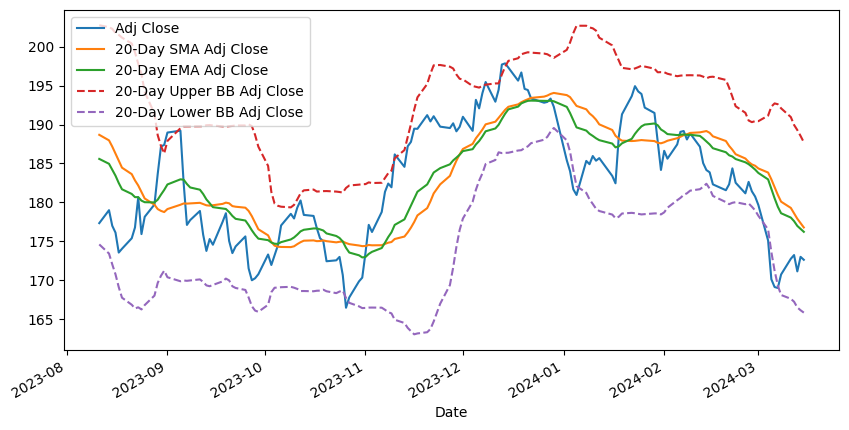

In [20]:
# Plot SMA, EMA and price for AAPL. Note how EMA responds quicker to price swings than SMA
aapl_df = df[df['Symbol'] == 'AAPL'].tail(150)
cols_to_plot = ['Adj Close', '20-Day SMA Adj Close', '20-Day EMA Adj Close', '20-Day Upper BB Adj Close', '20-Day Lower BB Adj Close']
line_styles = {'20-Day Upper BB Adj Close': '--', '20-Day Lower BB Adj Close': '--'}
aapl_df.plot(x ='Date', y=cols_to_plot, figsize=(10, 5), style=line_styles)

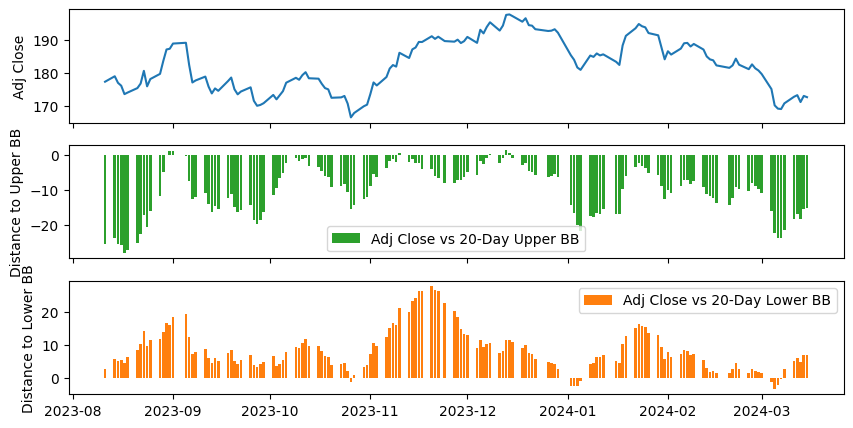

In [21]:
# Plot price vs distance to bollinger bands
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 5))  # Two subplots sharing the same x axis

# Plot the stock price on the first (top) subplot
ax1.plot(aapl_df['Date'], aapl_df['Adj Close'], color='tab:blue')
ax1.set_ylabel('Adj Close')

# Plot the BBs and distance to BBs on the second (bottom) subplot
ax2.bar(aapl_df['Date'], aapl_df['Adj Close vs 20-Day Upper BB'], color='tab:green', label='Adj Close vs 20-Day Upper BB')
ax3.bar(aapl_df['Date'], aapl_df['Adj Close vs 20-Day Lower BB'], color='tab:orange', label='Adj Close vs 20-Day Lower BB')
ax2.set_ylabel('Distance to Upper BB')
ax3.set_ylabel('Distance to Lower BB')
ax2.legend()
ax3.legend()
plt.show()

In [22]:
# MACD https://www.investopedia.com/terms/m/macd.asp
df['MACD'] = df['12-Day EMA Adj Close'] - df['26-Day EMA Adj Close']
df['MACD Signal Line'] = df.groupby('Symbol')['MACD'].transform(lambda x: x.ewm(span=9, min_periods=9).mean())
df['MACD Histogram'] = df['MACD'] - df['MACD Signal Line']

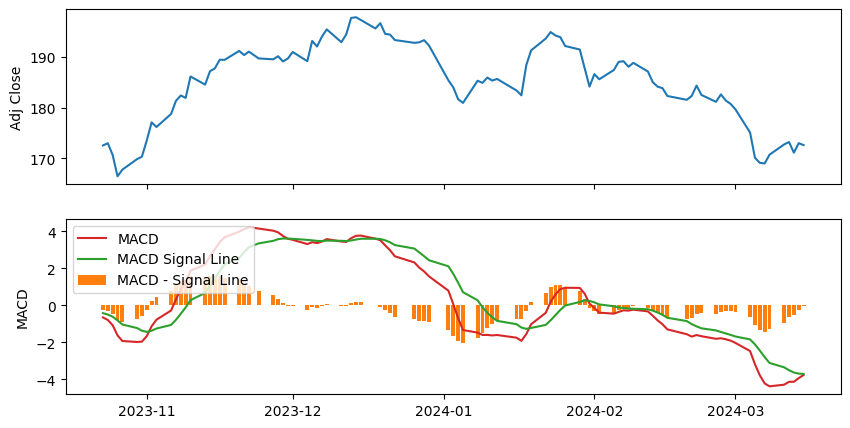

In [23]:
# Plot MACD and MACD Signal for AAPL
aapl_df = df[df['Symbol'] == 'AAPL'].tail(100)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))  # Two subplots sharing the same x axis

# Plot the stock price on the first (top) subplot
ax1.plot(aapl_df['Date'], aapl_df['Adj Close'], color='tab:blue')
ax1.set_ylabel('Adj Close')

# Plot the MACD line and signal line on the second (bottom) subplot
ax2.plot(aapl_df['Date'], aapl_df['MACD'], color='tab:red', label='MACD')
ax2.plot(aapl_df['Date'], aapl_df['MACD Signal Line'], color='tab:green', label='MACD Signal Line')
ax2.bar(aapl_df['Date'], aapl_df['MACD Histogram'], color='tab:orange', label='MACD - Signal Line')
ax2.set_ylabel('MACD')
ax2.legend(loc='upper left')
plt.show()

In [24]:
# Calculate average true range (ATR) which is a measure of volatility
df['High minus Low'] = df['High'] - df['Low']
df['Yesterday Adj Close'] = df.groupby('Symbol')['Adj Close'].shift(1)
df['Abs. High - Yesterday Adj Close'] = (df['High'] - df['Yesterday Adj Close']).abs()
df['Abs. Low - Yesterday Adj Close'] = (df['Low'] - df['Yesterday Adj Close']).abs()
df['True Range'] = df[['High minus Low', 'Abs. High - Yesterday Adj Close', 'Abs. Low - Yesterday Adj Close']].max(axis=1)
df.drop(['High minus Low', 'Abs. High - Yesterday Adj Close', 'Abs. Low - Yesterday Adj Close'], axis=1, inplace=True)
df['26-Day Average True Range'] = df.groupby('Symbol')['True Range'].transform(lambda x: x.rolling(26).mean())

# Calculate MACD-V
df['MACD-V'] = 100 * (df['12-Day EMA Adj Close'] - df['26-Day EMA Adj Close']) / df['26-Day Average True Range']
df['MACD-V Signal Line'] = df.groupby('Symbol')['MACD-V'].transform(lambda x: x.ewm(span=9, min_periods=9).mean())
df['MACD-V Histogram'] = df['MACD-V'] - df['MACD-V Signal Line']

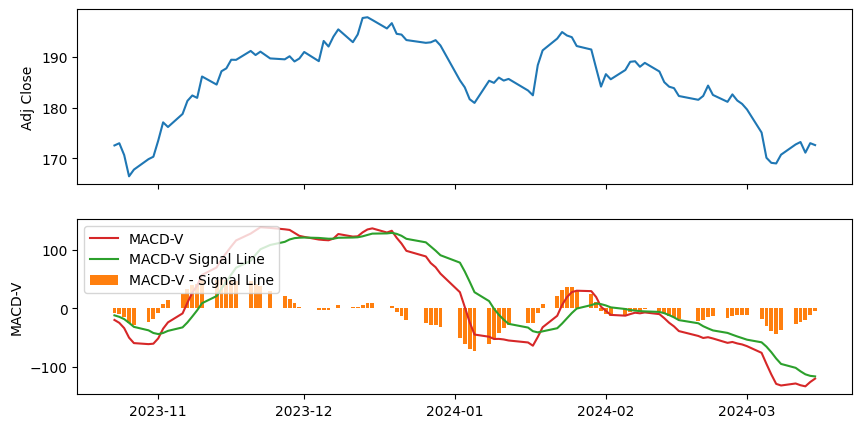

In [25]:
# Plot MACD-V and MACD-V Signal for AAPL
aapl_df = df[df['Symbol'] == 'AAPL'].tail(100)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 5))  # Two subplots sharing the same x axis

# Plot the stock price on the first (top) subplot
ax1.plot(aapl_df['Date'], aapl_df['Adj Close'], color='tab:blue')
ax1.set_ylabel('Adj Close')

# Plot the MACD-V line and signal line on the second (bottom) subplot
ax2.plot(aapl_df['Date'], aapl_df['MACD-V'], color='tab:red', label='MACD-V')
ax2.plot(aapl_df['Date'], aapl_df['MACD-V Signal Line'], color='tab:green', label='MACD-V Signal Line')
ax2.bar(aapl_df['Date'], aapl_df['MACD-V Histogram'], color='tab:orange', label='MACD-V - Signal Line')
ax2.set_ylabel('MACD-V')
ax2.legend(loc='upper left')
plt.show()

# Classifier 1: Logistic Regression

# Classifier 2:

# Classifier 3: 

In [26]:
# Remember to order dataframe by date 
# Use meta labelling to train a model to predict False Positives! Do some sort of feature selection and hyperparameter tuning.

In [27]:
# Come up with a starategy based on the prediction